# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

Проект можно разделить на следующие задачи:

- Провести исследовательский анализ набора фотографий;
- Подготовить данные к обучению;
- Обучить нейронную сеть и рассчитайть её качество.


Описание данных:

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 
В  распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

## Исследовательский анализ данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale=1./255) 

datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory = '/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224), 
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


Необходимо посмотреть на размер выборки, построить график распределения возраста, напечатать на экране 10-15 фотографий, посмотреть, как устроен датасет.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
data.shape

(7591, 2)

In [7]:
data.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [8]:
data.duplicated().sum()

0

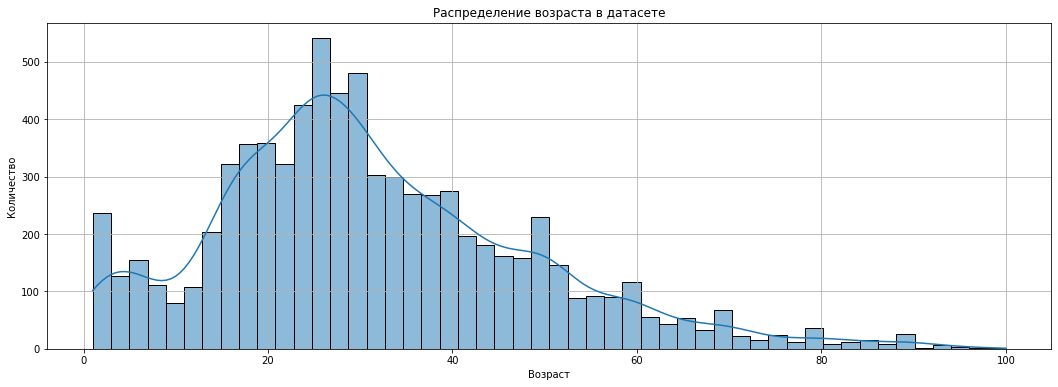

In [9]:
plt.figure(figsize=(18, 6))
sns.histplot(data['real_age'], bins=50, kde=True)
plt.title('Распределение возраста в датасете')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

Возраст людей от одного года до 100. Скорее всего это связано с округлением.Наибольшее число фотографий людей в возрасте от 20 до 41 года. Есть несколько пиков. 

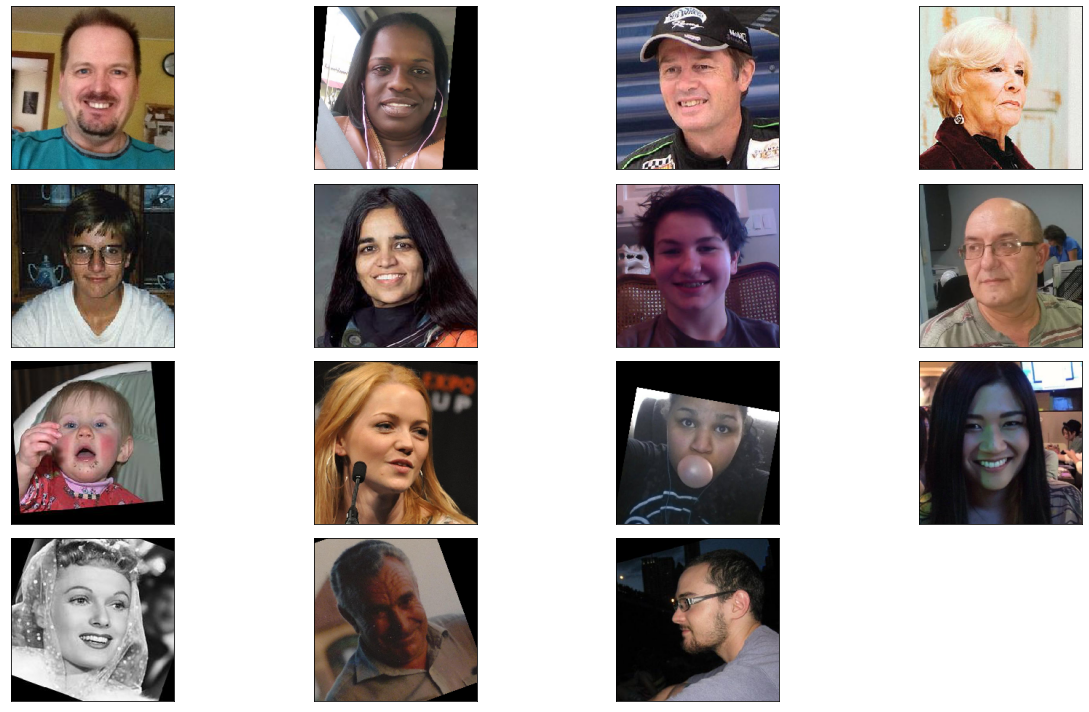

In [10]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(18,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Датасет состоит из 7591 изображения, пропусков и дубликатов нет. Большинство людей на фото в возрасте от 20 до 41 года. В наборе есть, как и цветные, так и чернобелые фотографии. Перед лицами на некоторых фотографиях встречаются посторонние предметы, лица могут находится под разными ракурсами. В целом можно заключить, что данные готовы для обучения модели и дополнительная обработка не требуется.

## Обучение модели

Нужно построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Значения MAE на тестовой выборке должны быть не больше 8.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

 def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True, 
        vertical_flip=True
    )
    train_data = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_data  

def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255
    )
    valid_data = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',        
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return valid_data  

def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(
        optimizer=Adam(learning_rate=1e-4),   
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)    

    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,  
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-05-07 08:40:06.336278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-07 08:40:06.905463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 78s - loss: 288.8289 - mae: 12.4516 - val_loss: 450.7334 - val_mae: 16.1490
Epoch 2/10
178/178 - 46s - loss: 110.1154 - mae: 7.9663 - val_loss: 776.6521 - val_mae: 22.9601
Epoch 3/10
178/178 - 49s - loss: 85.4046 - mae: 7.0358 - val_loss: 247.1140 - val_mae: 12.2086
Epoch 4/10
178/178 - 49s - loss: 70.5292 - mae: 6.4292 - val_loss: 140.1513 - val_mae: 9.0258
Epoch 5/10
178/178 - 49s - loss: 55.5550 - mae: 5.6871 - val_loss: 130.3106 - val_mae: 8.4192
Epoch 6/10
178/178 - 49s - loss: 45.7045 - mae: 5.1454 - val_loss: 81.7494 - val_mae: 6.9024
Epoch 7/10
178/178 - 49s - loss: 39.7680 - mae: 4.7496 - val_loss: 78.9176 - val_mae: 6.7601
Epoch 8/10
178/178 - 50s - loss: 33.4809 - mae: 4.4219 - val_loss: 97.7618 - val_mae: 7.5083
Epoch 9/10
178/178 - 49s - loss: 30.2907 - mae: 4.2216 - val_loss: 108.7742 - val_mae: 7.6826
Epoch 10/10
178/178 - 50s - loss: 27.4966 - mae: 4.0036 - val_loss: 87.2180 - val_mae: 7.0354
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
60/60 - 12s - loss: 87.2180 - mae: 7.0354


```

## Анализ обученной модели

Для модели была использована сверточная нейронная сеть ResNet50. Время обчуния меньше 9 минут. MAE модели составляет 7.0354, погрешность предсказания 7 лет.

Для решения первой задачи, а именно определения возрастной группы пользователей данная модель может применятся. Для контроля же добросовестности кассиров при продаже алкоголя она не подойдет, слишком большая погрешность, возможно стоит использовать другую модель.